# RC experiment analysis (WheatFspm)

The following notebook analyzes the results generated by `2022_03_30_multirun_pipeline.ipynb`.

In [245]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [246]:
RESULTS_CSV = 'test_results.csv'

### Loading the experiment results

In [247]:
data = pd.read_csv(RESULTS_CSV)

targets = data['target'].unique().tolist()
state_vars = data['state_var'].unique().tolist()
datasets = data['dataset'].unique().tolist()

data = data.set_index(['target', 'state_var', 'dataset'])
data.head(5)

Unnamed: 0  test_score  \
target                state_var            dataset                            
input_air_temperature state__An            NEMA_H0            0   -0.399352   
                                           NEMA_H3            1   -0.652902   
                                           NEMA_H15           2   -0.393598   
                                           combined           3   -0.373257   
                      state__Transpiration NEMA_H0            4   -0.469686   

                                                     train_mean  train_std  \
target                state_var            dataset                           
input_air_temperature state__An            NEMA_H0    -0.230236   0.019201   
                                           NEMA_H3    -0.195643   0.024072   
                                           NEMA_H15   -0.306023   0.013792   
                                           combined   -0.263725   0.018267   
                      state__Transpiration NEMA_H0    -0.200324   0.024970   

                                                      cv_mean    cv_std  
target                state_var            dataset                       
input_air_temperature state__An            NEMA_H0  -0.394548  0.081092  
                                           NEMA_H3  -0.279485  0.062588  
                                           NEMA_H15 -0.473073  0.063097  
                                           combined -0.375859  0.041791  
                      state__Transpiration NEMA_H0  -0.556837  0.137555

In [248]:
print(f'n_targets:    {len(targets)}')
print(f'n_state_vars: {len(state_vars)}')
print(f'n_datasets:    {len(datasets)}')


n_targets:    9
n_state_vars: 12
n_datasets:    4


### Predictive performance per target

Ranking the predictive performance per target:

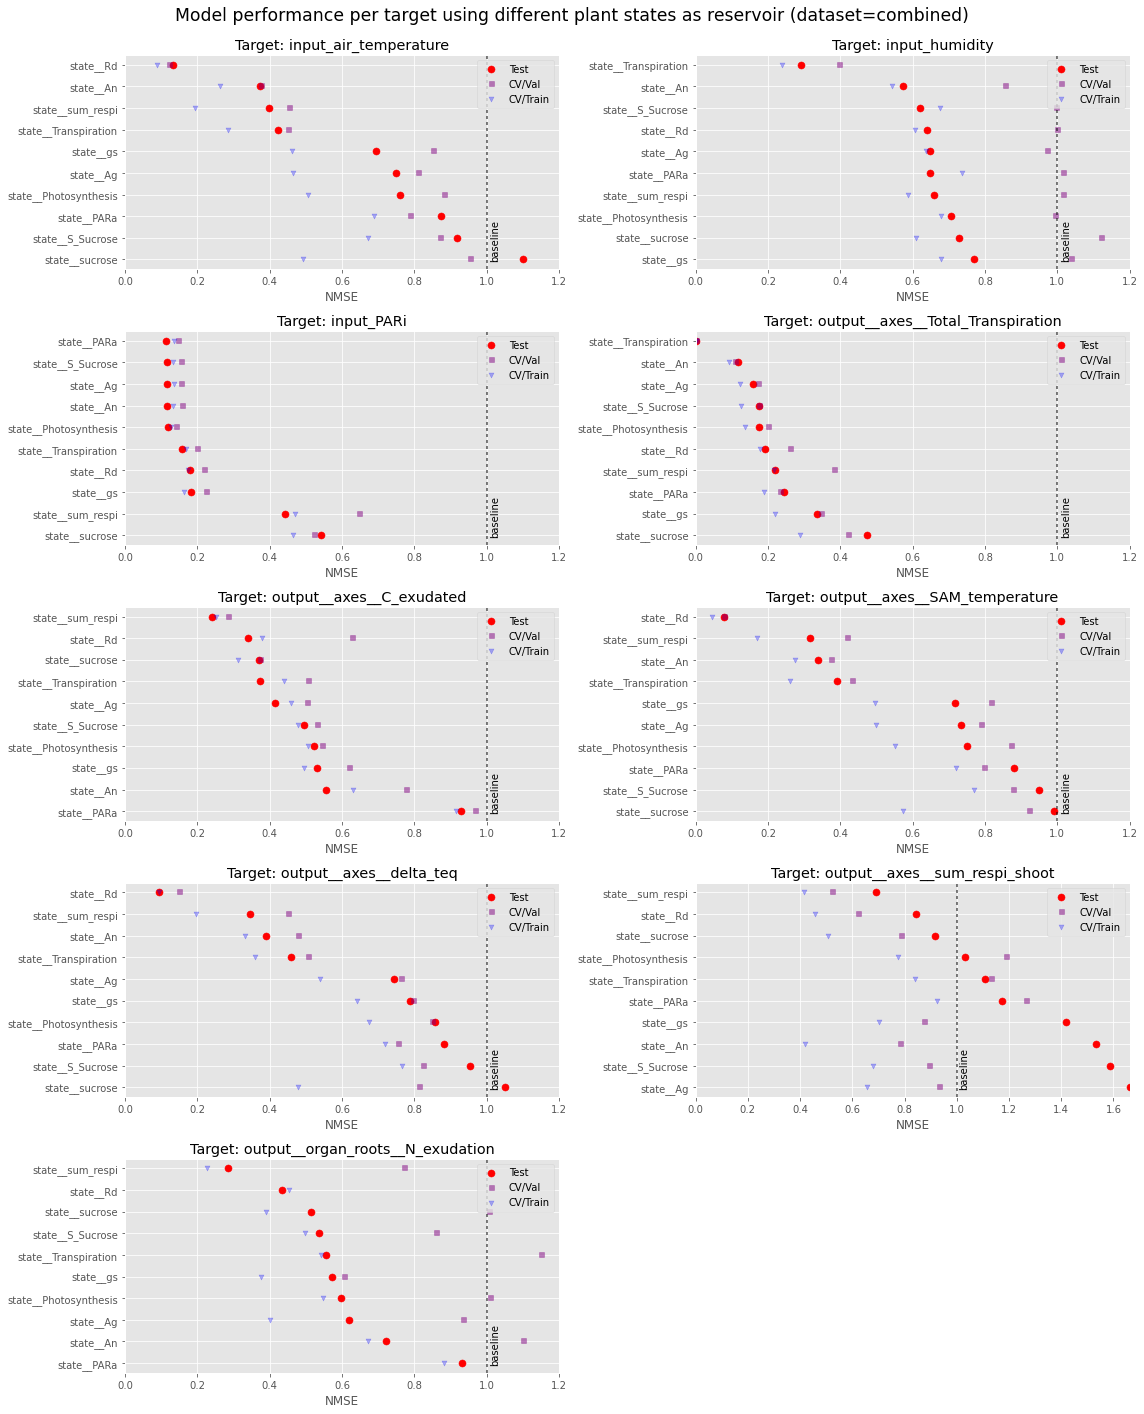

In [249]:
DATASET = 'combined'
DO_NOT_PLOT = ['state__Ts', 'state__Tr']


with plt.style.context('ggplot'):
  n_cols = 2
  n_rows = np.ceil(len(targets) / n_cols).astype(int)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 20), squeeze=False, 
                          tight_layout=True, sharey=False)


  for target, ax in zip(targets, axs.flatten()):
    plot_data = data.loc[target, :, DATASET]
    plot_data = plot_data.sort_values(by='test_score', ascending=True)
    plot_data = plot_data.loc[~plot_data.index.isin(DO_NOT_PLOT)]
    
    x = np.arange(len(state_vars) - len(DO_NOT_PLOT))
    ax.set_yticks(np.arange(len(state_vars) - len(DO_NOT_PLOT)))

    ax.set_xlim(0, max(1.2, (-plot_data['test_score']).max()))
    # ax.set_xlim(0, 1.2)
    ax.scatter(-plot_data['test_score'], x, label='Test', color='red', alpha=1, marker='o', s=50)
    ax.scatter(-plot_data['cv_mean'], x, label='CV/Val', color='purple', alpha=0.5, marker=',', s=25)
    ax.scatter(-plot_data['train_mean'], x, label='CV/Train', color='blue', alpha=0.3, marker='v', s=25)
    
    ax.axvline(1, dashes=(2, 2), color='black', alpha=0.66)
    ax.text(1.01, 0, 'baseline', fontsize='medium', rotation='vertical')
  
    ax.legend(loc='upper right')
    ax.set_title(f'Target: {target}')
    ax.set_yticklabels(plot_data.index)
    ax.set_xlabel('NMSE')

  for ax in axs.flatten()[len(targets):]:
    ax.remove()

  fig.suptitle(f'Model performance per target using different plant states as reservoir (dataset={DATASET})\n', size='xx-large')

  plt.show()
  

### Predictive performance of different state variables as reservoir

**Note:** 'state__Ts' and 'state__Tr' are not plotted because they contain outliers for some targets.

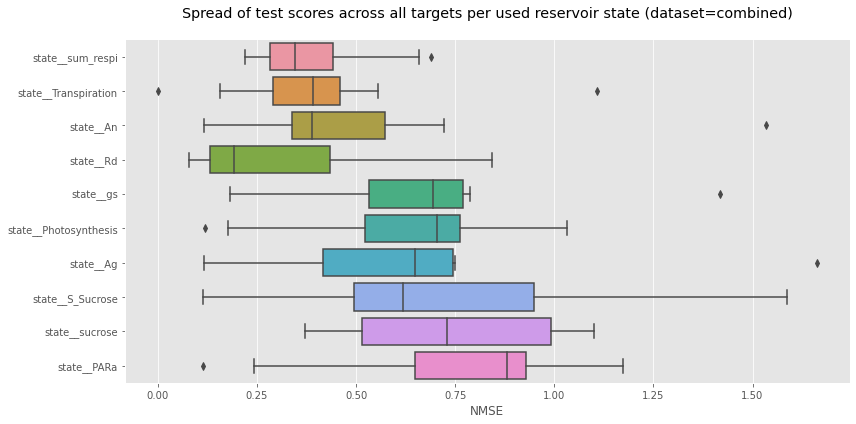

In [250]:
DATASET = 'combined'
DO_NOT_PLOT = ['state__Ts', 'state__Tr']
# DO_NOT_PLOT = []


with plt.style.context('ggplot'):

  order = data.groupby('state_var').mean().sort_values(by='test_score', ascending=False).index
  plot_data = data.loc[:, order, DATASET].reset_index()
  plot_data = plot_data[~plot_data['state_var'].isin(DO_NOT_PLOT)]
  plot_data['test_score'] *= -1
  (sns
    .catplot(y='state_var', x='test_score', kind='box', orient='h', data=plot_data, height=6, aspect=2)
    .set(title=f'Spread of test scores across all targets per used reservoir state (dataset={DATASET})\n', )
    .set(ylabel='', xlabel='NMSE'))

  plt.tight_layout()
  plt.show()

### Investigating outlier scores for `state__Ts` and `state__Tr` reservoirs

In [314]:
subdata = data.loc[:, ['state__Ts', 'state__Tr'], :].reset_index()

                               target  state_var   dataset  Unnamed: 0  \
5                      input_humidity  state__Ts   NEMA_H3          61   
6                      input_humidity  state__Ts  NEMA_H15          62   
7                      input_humidity  state__Ts  combined          63   
13  output__axes__Total_Transpiration  state__Ts   NEMA_H3         157   
15  output__axes__Total_Transpiration  state__Ts  combined         159   

    test_score  train_mean  train_std   cv_mean    cv_std  
5    18.667065   -0.163214   0.005561  0.310983  0.086014  
6    11.723441   -0.163044   0.006044  0.316708  0.015961  
7     7.852904   -0.181738   0.008860  0.281239  0.038543  
13   11.128117   -0.114471   0.016056  0.182667  0.062268  
15    6.503698   -0.110833   0.030040  0.204288  0.094659  


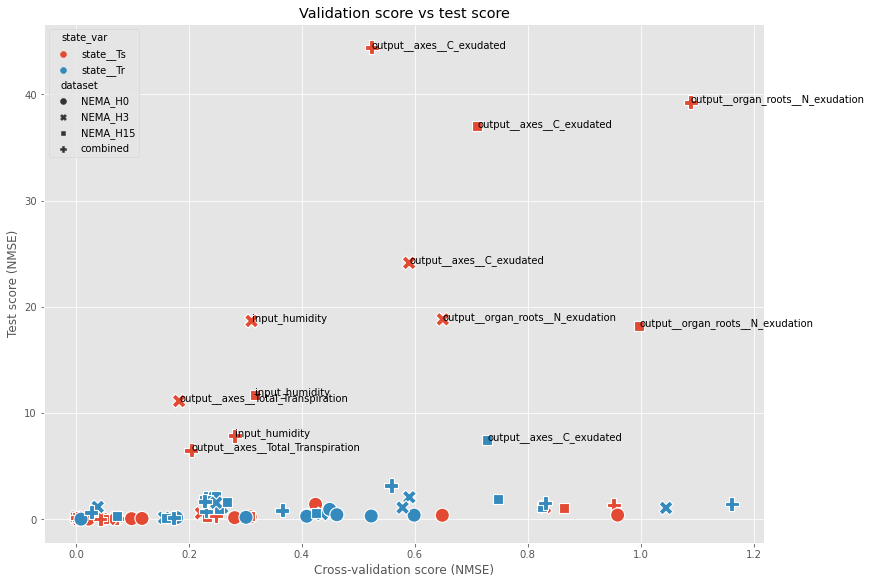

In [317]:
with plt.style.context('ggplot'):
  plot_data = subdata.copy()
  plot_data['test_score'] *= -1
  plot_data['cv_mean'] *= -1
  fig, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
  sns.scatterplot(x='cv_mean', y='test_score', hue='state_var', style='dataset', s=200, data=plot_data, ax=ax)
  ax.set_title('Validation score vs test score')
  ax.set_xlabel('Cross-validation score (NMSE)')
  ax.set_ylabel('Test score (NMSE)')

  # label outliers
  outlier_data = plot_data[plot_data['test_score'] > 5]
  print(outlier_data.head())

  def print_annotation(row):
    ax.text(row['cv_mean'], row['test_score'], row['target'], rotation=0)

  outlier_data.apply(print_annotation, axis=1)

  plt.show()